## Hotel booking demand
<p>I used hotel demand data on Kaggle to create a data exploration and forecasting machine learning model.</p>
<a href='https://www.kaggle.com/jessemostipak/hotel-booking-demand'>The data that I used </a>

In [199]:
import random
from collections import defaultdict
from itertools import product

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg') 
from scipy import stats
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV

from sklearn.metrics import r2_score, mean_squared_error,roc_curve, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression


from dmba import classificationSummary,stepwise_selection,AIC_score
from imblearn.over_sampling import SMOTE
 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

import pydotplus as pdp



In [194]:
hotel = pd.read_csv('hotel_bookings.csv')
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [43]:
hotel.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [44]:
#describe all columns
print(hotel.describe())


         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000            

In [72]:
#inspect each categories columns
print(hotel.columns)
#is_canceled
print('##is_canceled##')
print(hotel.is_canceled.value_counts())

#hotel
print('###hotel###')
print(hotel.hotel.value_counts())

#deposit_type
print('###deposite_type###')
print(hotel.deposit_type.value_counts())

#customer_type
print('###customer_type###')
print(hotel.customer_type.value_counts())

#meal
print('###meal###')
print(hotel.meal.value_counts())

#market_segment
print('###market_segment###')
print(hotel.market_segment.value_counts())

#reserved_room_type
print('###reserved_room###')
print(hotel.reserved_room_type.value_counts())

#country
print('###country###')
print(hotel.country.value_counts())










Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')
##is_canceled##
0    75166
1    44224
Name: is_canceled, dtype: int64
###hotel###
City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64
###deposite_type###
No Deposit    104641
Non Refund     14587
Refundable       162
Name: deposit_type, dtype: int64
###customer_ty

## inspect seasonal demands

In [3]:
#make id column for counting values
hotel['id'] = np.arange(hotel.shape[0])
seasonal = hotel.groupby('arrival_date_month').id.count().reset_index()
seasonal


,arrival_date_month,id
0,April,11089
1,August,13877
2,December,6780
3,February,8068
4,January,5929
5,July,12661
6,June,10939
7,March,9794
8,May,11791
9,November,6794


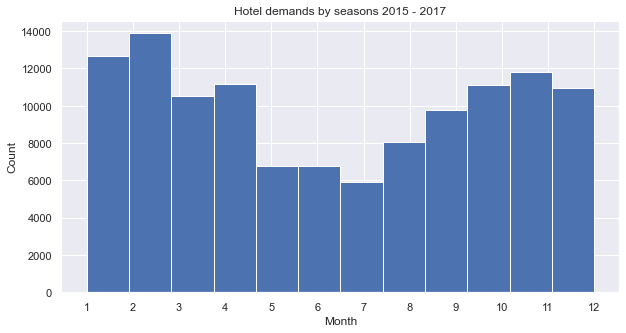

In [4]:
#set seaborn theme
sns.set()

f,ax = plt.subplots(figsize=(10,5))
ax.hist(hotel.arrival_date_month,bins=12)
ax.set_title('Hotel demands by seasons 2015 - 2017')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

month = list(range(1,13))
ax.set_xticklabels(month)


plt.show()

/opt/anaconda3/envs/tf3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


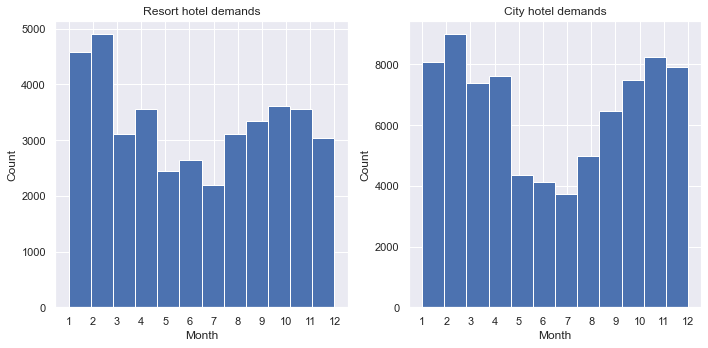

In [5]:
#see any defferencies between resort hotels and city hotels by using a histgram
#resort hotel 
resort = hotel.loc[hotel['hotel']=='Resort Hotel']

#city hotel
city = hotel.loc[hotel['hotel']=='City Hotel']

#set searborn theme
sns.set()

fig = plt.figure(figsize=(10,5))
#top
#resort hotel's histgram
ax1 = fig.add_subplot(1,2,1)
ax1.hist(resort.arrival_date_month,bins=12)
ax1.set_title('Resort hotel demands')
ax1.set_xlabel('Month')
ax1.set_ylabel('Count')

month = list(range(1,13))
ax1.set_xticklabels(month)

#bottom
#resort city hotel's histgram
ax2 = fig.add_subplot(1,2,2)
ax2.hist(city.arrival_date_month,bins=12)
ax2.set_title('City hotel demands')
ax2.set_xlabel('Month')
ax2.set_ylabel('Count')

month = list(range(1,13))
ax2.set_xticklabels(month)

# show plots
fig.tight_layout()
fig.show()


In [6]:
#compare ratio of cancellation based on city hotels and resort hotels
#resort hotel
resort_canceld = round(resort['is_canceled'].sum() / len(resort) * 100)

#city
city_canceld = round(city['is_canceled'].sum() / len(city) * 100)

print('The ratio of cancellation')
print('resort:{}%'.format(int(resort_canceld)))
print('city:{}%'.format(int(resort_canceld)))

The ratio of cancellation
resort:28%
city:28%


## Comparison of groups with and without children

/opt/anaconda3/envs/tf3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


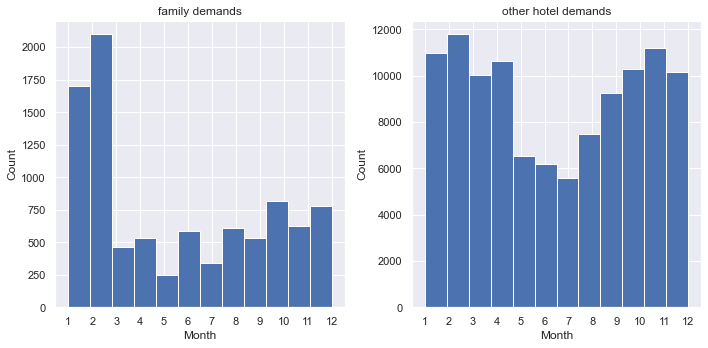

In [7]:
#see any defferencies between family who have children and others by using a histgram

#set function to classify whether family or not
def fam_detector(df):
    c = hotel['children'] # have children
    b = hotel['babies'] # have babies
    if (c >=1) or (b >=1) :
        return 1
    else:
        return 0


#make plot 
family = hotel.loc[(hotel['children']>=1) | (hotel['babies']>=1) ]
other = hotel.loc[(hotel['children']==0) & (hotel['babies']==0)]

#set searborn theme
sns.set()

fig = plt.figure(figsize=(10,5))
#top
#resort hotel's histgram
ax1 = fig.add_subplot(1,2,1)
ax1.hist(family.arrival_date_month,bins=12)
ax1.set_title('family demands')
ax1.set_xlabel('Month')
ax1.set_ylabel('Count')

month = list(range(1,13))
ax1.set_xticklabels(month)

#bottom
#resort city hotel's histgram
ax2 = fig.add_subplot(1,2,2)
ax2.hist(other.arrival_date_month,bins=12)
ax2.set_title('other hotel demands')
ax2.set_xlabel('Month')
ax2.set_ylabel('Count')

month = list(range(1,13))
ax2.set_xticklabels(month)

# show plots
fig.tight_layout()
fig.show()


In [8]:
#make new column have_babies and have_children
def fam_classifier(x):
    if x >= 1:
        return 1
    else:
        return 0
    

hotel['have_babies'] = hotel.babies.apply(lambda x:fam_classifier(x))
hotel['have_children'] = hotel.children.apply(lambda x:fam_classifier(x))

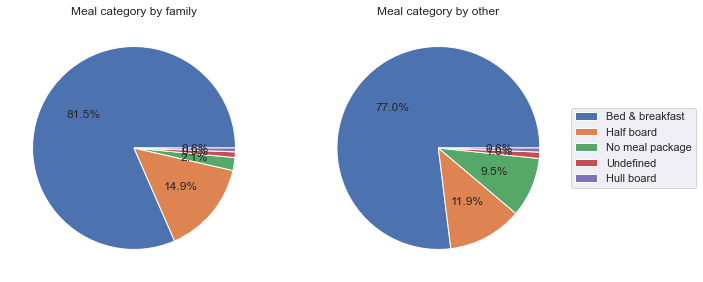

In [9]:
#make a pie chart to visualize a meal column

#set searborn theme
sns.set()

fig = plt.figure(figsize=(10,8))

labels = ['Bed & breakfast','Half board','No meal package','Undefined','Hull board']
y_f = family['meal'].value_counts() # family 
y_o = other['meal'].value_counts() # other

ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(y_f, autopct='%1.1f%%')
ax1.set_title('Meal category by family')

ax2 = fig.add_subplot(1,2,2)
ax2.pie(y_o,autopct='%1.1f%%')
ax2.set_title('Meal category by other')
ax2.legend(labels,fancybox=True,loc='center left',bbox_to_anchor=(1.0,0.5))




plt.show()

<h4>Reference of a meal column</h4>
<p>Categories are presented in standard hospitality meal packages</p>
<ul>
    <li>Undefined/SC – no meal package</li>
    <li>BB – Bed & Breakfast</li>
    <li>HB – Half board (breakfast and one other meal – usually dinner)</li>
    <li>FB – Full board (breakfast, lunch and dinner)</li>
    </ul>
    

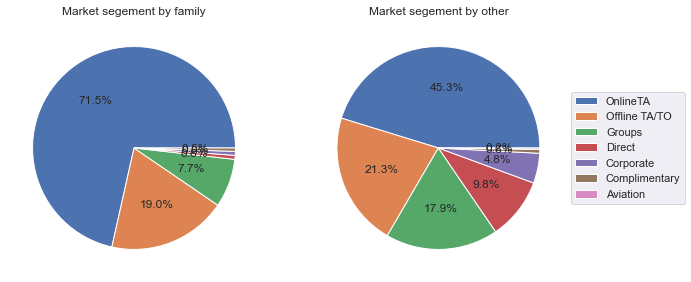

In [10]:
#make a pie chart to visualize a market segment column

#set searborn theme
sns.set()
'''Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
'''

labels = ['OnlineTA','Offline TA/TO','Groups','Direct','Corporate','Complimentary','Aviation','Undefined']
fig = plt.figure(figsize=(10,15))

y_f = family['market_segment'].value_counts() # family 
y_o = other['market_segment'].value_counts() # other

ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(y_f, autopct='%1.1f%%')
ax1.set_title('Market segement by family')

ax2 = fig.add_subplot(1,2,2)
ax2.pie(y_o,autopct='%1.1f%%')
ax2.set_title('Market segement by other')
ax2.legend(labels,fancybox=True,loc='center left',bbox_to_anchor=(1.0,0.5))




plt.show()

<h4>Reference of a meal column</h4>
<p>Market segment designation</p>
<p>In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” </P>

In [11]:
#compare ratio of cancellation based on family and other group
#family
family_canceld = round(family['is_canceled'].sum() / len(family) * 100)

#other 
other_canceld = round(other['is_canceled'].sum() / len(other) * 100)

print('The ratio of cancellation')
print('family:{}%'.format(int(family_canceld)))
print('other:{}%'.format(int(other_canceld)))

The ratio of cancellation
family:35%
other:37%


<h3>I hypothesize that the more lead time increases, the more cancellation rate increase. Those items might correlate.</h3>

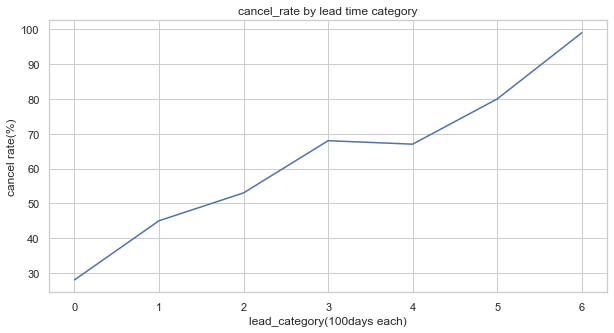

Correlation:0.9808017989920034


In [12]:
#Separate the lead time columns by 100 units each.
def lead_time_clasifier(x):
    if x <= 100:
        return 0
    elif x <= 200:
        return 1
    elif x <= 300:
        return 2
    elif x <= 400:
        return 3
    elif x <= 500:
        return 4
    elif x <= 600:
        return 5
    elif x > 600:
        return 6
   
    
hotel['lead_category'] = hotel.lead_time.apply(lambda x:lead_time_clasifier(x))

#make group by lead_category
lead_cancel = hotel.groupby('lead_category').is_canceled.sum().reset_index()
lead_canceled = hotel.groupby('lead_category').is_canceled.count().reset_index()

lead_cancel = pd.merge(lead_cancel,lead_canceled,on='lead_category',how='left')

lead_cancel=lead_cancel.rename(columns={'is_canceled_x':'canceled','is_canceled_y':'total'})

lead_cancel['cancel_rate(%)'] = lead_cancel.apply(lambda x: int(round(x.canceled / x.total*100.0)),axis=1)



#make plot
sns.set_style('whitegrid')
f = plt.figure(figsize=(10,5))
ax = sns.lineplot(x="lead_category", y="cancel_rate(%)", data=lead_cancel)
ax.set_title('cancel_rate by lead time category')
ax.set_xlabel('lead_category(100days each)')
ax.set_ylabel('cancel rate(%)')

plt.show()

#calculate a correlation
corr,_ = stats.pearsonr(lead_cancel['lead_category'],lead_cancel['cancel_rate(%)'])
print('Correlation:{}'.format(corr))





        
        

## Classification model that can predict whether users may cancel or not.

In [102]:
#make classification model that can predict user cancellation

#prepare data for the model
#make category column numeric
hotel = pd.get_dummies(hotel,columns=['hotel','deposit_type','customer_type','meal','market_segment','reserved_room_type','distribution_channel'], dummy_na=True,drop_first=True)
hotel = hotel.dropna()
#drop nan value


In [118]:
#set feature and label
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children','babies', 'is_repeated_guest','previous_cancellations', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces','total_of_special_requests', 'hotel_Resort Hotel','deposit_type_Non Refund', 'deposit_type_Refundable', 'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'meal_FB','meal_HB', 'meal_SC', 'meal_Undefined','market_segment_Complementary', 'market_segment_Corporate','market_segment_Direct', 'market_segment_Groups','market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Undefined', 'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D','reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L', 'reserved_room_type_P','distribution_channel_Direct','distribution_channel_GDS', 'distribution_channel_TA/TO','distribution_channel_Undefined']
label = 'is_canceled'

#use SMOTE to do oversampling
X_resampled, y_resampled = SMOTE().fit_resample(hotel[features], hotel[label])

#standize data
scaler = StandardScaler()
scaled = scaler.fit_transform(X_resampled)

#split the data to train and test data
X_train,X_test,y_train,y_test = train_test_split(scaled,y_resampled,random_state=1)

#call RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=1,oob_score=True)

#train data
forest.fit(X_train,y_train)

#evaluate data
score = forest.score(X_test,y_test)

print(score)

0.96


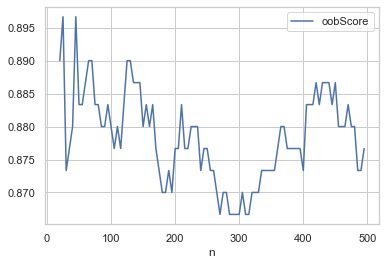

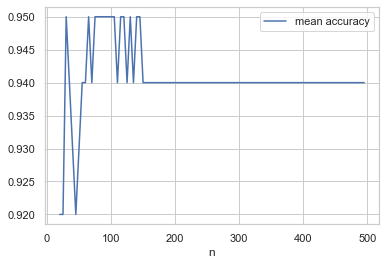

In [91]:
#explore how many trees they are suitable for the model
n_estimator = list(range(20, 500, 5))
oobScores = []
scores = []

for n in n_estimator:
    forest = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    forest.fit(X_train,y_train)
    oobScores.append(forest.oob_score_)
    scores.append(forest.score(X_test,y_test))
    
pd.DataFrame({'n':n_estimator,
             'oobScore':oobScores
             }).plot(x='n',y='oobScore')

pd.DataFrame({'n':n_estimator,
             'mean accuracy':scores
             }).plot(x='n',y='mean accuracy')



In [106]:
#evaluate features
rf = RandomForestClassifier(n_estimators=400)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    X_train,X_test,y_train,y_test = train_test_split(hotel[features],hotel[label],random_state=1)
    rf.fit(X_train,y_train)
    acc = metrics.accuracy_score(y_test, rf.predict(X_test))
    for column in hotel[features].columns:
        X_t = X_test.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(y_test, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))


Features sorted by their score:
[(0.02, 'stays_in_week_nights'), (0.02, 'lead_time'), (0.0133, 'stays_in_weekend_nights'), (0.0067, 'distribution_channel_TA/TO'), (0.0, 'total_of_special_requests'), (0.0, 'reserved_room_type_P'), (0.0, 'reserved_room_type_L'), (0.0, 'reserved_room_type_H'), (0.0, 'reserved_room_type_G'), (0.0, 'reserved_room_type_F'), (0.0, 'reserved_room_type_E'), (0.0, 'reserved_room_type_D'), (0.0, 'reserved_room_type_C'), (0.0, 'reserved_room_type_B'), (0.0, 'required_car_parking_spaces'), (0.0, 'previous_cancellations'), (0.0, 'meal_Undefined'), (0.0, 'meal_SC'), (0.0, 'meal_HB'), (0.0, 'meal_FB'), (0.0, 'market_segment_Undefined'), (0.0, 'market_segment_Online TA'), (0.0, 'market_segment_Offline TA/TO'), (0.0, 'market_segment_Groups'), (0.0, 'market_segment_Direct'), (0.0, 'market_segment_Corporate'), (0.0, 'market_segment_Complementary'), (0.0, 'is_repeated_guest'), (0.0, 'hotel_Resort Hotel'), (0.0, 'distribution_channel_Undefined'), (0.0, 'distribution_channel

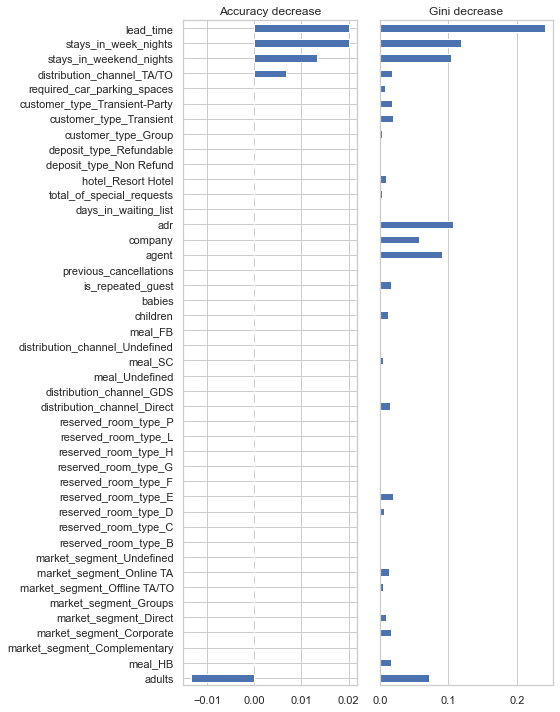

In [107]:
#measure variable importance
importances = rf.feature_importances_

df = pd.DataFrame({
    'feature': hotel[features].columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         hotel[features].columns],
    'Gini decrease': rf.feature_importances_, 
    'Entropy decrease': rf.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 10))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')
ax.set_title('Accuracy decrease')
ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)
ax.set_title('Gini decrease')

plt.tight_layout()
plt.show()

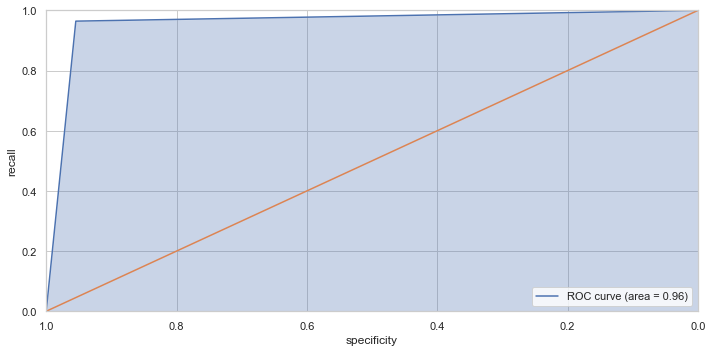

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, forest.predict(X_test))
roc_df = pd.DataFrame({'recall': tpr, 'specificity':1- fpr})
auc = metrics.auc(fpr, tpr)

ax = roc_df.plot(x='specificity', y='recall', figsize=(10, 5),label='ROC curve (area = %.2f)'%auc)
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
plt.grid(True)
plt.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

In [120]:
#trimed unnecessary columns
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children','is_repeated_guest', 'agent', 'company',
        'adr', 'required_car_parking_spaces','total_of_special_requests', 'hotel_Resort Hotel', 'deposit_type_Refundable', 'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party','meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Corporate','market_segment_Direct', 'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'reserved_room_type_D','reserved_room_type_E', 'distribution_channel_Direct','distribution_channel_TA/TO']



label = 'is_canceled'

#use SMOTE to do oversampling
X_resampled, y_resampled = SMOTE().fit_resample(hotel[features], hotel[label])

#standize data
scaler = StandardScaler()
scaled = scaler.fit_transform(X_resampled)

#split the data to train and test data
X_train,X_test,y_train,y_test = train_test_split(scaled,y_resampled,random_state=1)

#call RandomForestClassifier
forest = RandomForestClassifier(n_estimators=450, random_state=1,criterion='entropy', max_depth=5, oob_score=True)

#train data
forest.fit(X_train,y_train)

#evaluate data
score = forest.score(X_test,y_test)


print('The mean accuracy is {}'.format(score))
print('The generalization accuracy is {}'.format(forest.oob_score_))





The mean accuracy is 0.93
The generalization accuracy is 0.9


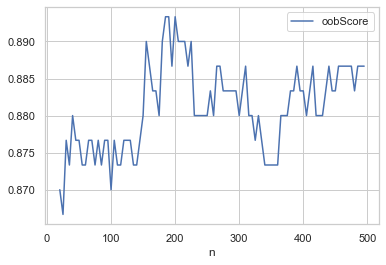

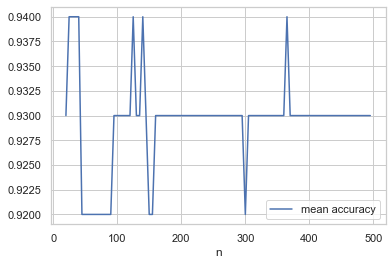

In [111]:
#explore how many trees they are suitable for the model
n_estimator = list(range(20, 500, 5))
oobScores = []
scores = []

for n in n_estimator:
    forest = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    forest.fit(X_train,y_train)
    oobScores.append(forest.oob_score_)
    scores.append(forest.score(X_test,y_test))
    
pd.DataFrame({'n':n_estimator,
             'oobScore':oobScores
             }).plot(x='n',y='oobScore')

pd.DataFrame({'n':n_estimator,
             'mean accuracy':scores
             }).plot(x='n',y='mean accuracy')


    

In [112]:
#itearte same process as first
#evaluate features
rf = RandomForestClassifier(n_estimators=380,random_state=1,oob_score=True)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    X_train,X_test,y_train,y_test = train_test_split(hotel[features],hotel[label],random_state=1)
    rf.fit(X_train,y_train)
    acc = metrics.accuracy_score(y_test, rf.predict(X_test))
    for column in hotel[features].columns:
        X_t = X_test.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(y_test, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))


Features sorted by their score:
[(0.0267, 'lead_time'), (0.0133, 'stays_in_weekend_nights'), (0.0133, 'stays_in_week_nights'), (0.0, 'total_of_special_requests'), (0.0, 'reserved_room_type_E'), (0.0, 'reserved_room_type_D'), (0.0, 'required_car_parking_spaces'), (0.0, 'meal_Undefined'), (0.0, 'meal_SC'), (0.0, 'meal_HB'), (0.0, 'market_segment_Online TA'), (0.0, 'market_segment_Offline TA/TO'), (0.0, 'market_segment_Direct'), (0.0, 'market_segment_Corporate'), (0.0, 'is_repeated_guest'), (0.0, 'hotel_Resort Hotel'), (0.0, 'distribution_channel_TA/TO'), (0.0, 'distribution_channel_Direct'), (0.0, 'deposit_type_Refundable'), (0.0, 'customer_type_Transient-Party'), (0.0, 'customer_type_Transient'), (0.0, 'customer_type_Group'), (0.0, 'company'), (0.0, 'children'), (0.0, 'agent'), (0.0, 'adr'), (-0.0133, 'adults')]


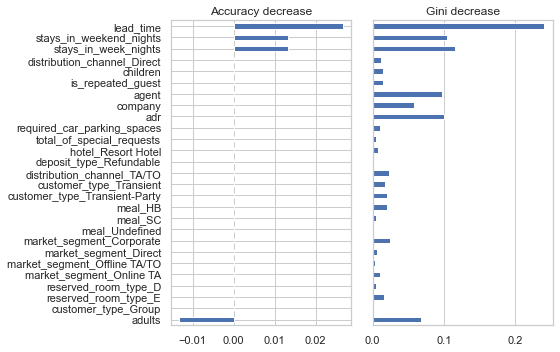

In [113]:
#measure variable importance
importances = rf.feature_importances_

df = pd.DataFrame({
    'feature': hotel[features].columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         hotel[features].columns],
    'Gini decrease': rf.feature_importances_, 
    'Entropy decrease': rf.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')
ax.set_title('Accuracy decrease')
ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)
ax.set_title('Gini decrease')

plt.tight_layout()
plt.show()

In [114]:
# Confusion matrix
classificationSummary(y_test, forest.predict(X_test), 
                      class_names=forest.classes_)

Confusion Matrix (Accuracy 0.8909)

       Prediction
Actual  0  1
     0 49  0
     1  6  0


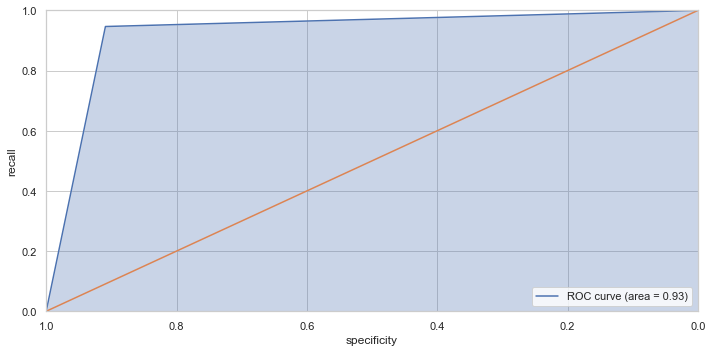

In [121]:
fpr, tpr, thresholds = roc_curve(y_test, forest.predict(X_test))
roc_df = pd.DataFrame({'recall': tpr, 'specificity':1- fpr})
auc = metrics.auc(fpr, tpr)

ax = roc_df.plot(x='specificity', y='recall', figsize=(10, 5),label='ROC curve (area = %.2f)'%auc)
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
plt.grid(True)
plt.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

In [154]:
#let's try logistic regression model
#set feature and label
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children','babies', 'is_repeated_guest','previous_cancellations', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces','total_of_special_requests', 'hotel_Resort Hotel','deposit_type_Non Refund', 'deposit_type_Refundable', 'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'meal_FB','meal_HB', 'meal_SC', 'meal_Undefined','market_segment_Complementary', 'market_segment_Corporate','market_segment_Direct', 'market_segment_Groups','market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Undefined', 'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D','reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L', 'reserved_room_type_P','distribution_channel_Direct','distribution_channel_GDS', 'distribution_channel_TA/TO','distribution_channel_Undefined']
label = 'is_canceled'

#use SMOTE to do oversampling
X_resampled, y_resampled = SMOTE().fit_resample(hotel[features], hotel[label])

#standize data
scaler = StandardScaler()
scaled = scaler.fit_transform(X_resampled)

#split the data to train and test data
X_train,X_test,y_train,y_test = train_test_split(scaled,y_resampled,random_state=1)


logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X_train, y_train)
print('score {}'.format(logit_reg.score(X_test,y_test)))

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)


score 0.91
intercept  -6.652003275428102
classes [0 1]


In [124]:
#evaluate features

# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    X_train,X_test,y_train,y_test = train_test_split(hotel[features],hotel[label],random_state=1)
    logit_reg.fit(X_train,y_train)
    acc = metrics.accuracy_score(y_test, logit_reg.predict(X_test))
    for column in hotel[features].columns:
        X_t = X_test.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(y_test, logit_reg.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))


Features sorted by their score:
[(0.039, 'hotel_Resort Hotel'), (0.0177, 'customer_type_Transient-Party'), (0.0142, 'customer_type_Transient'), (0.0133, 'lead_time'), (0.0071, 'company'), (0.0067, 'stays_in_weekend_nights'), (0.0067, 'stays_in_week_nights'), (0.0035, 'reserved_room_type_E'), (0.0035, 'is_repeated_guest'), (0.0035, 'distribution_channel_Direct'), (0.0035, 'children'), (0.0004, 'adults'), (0.0, 'reserved_room_type_P'), (0.0, 'reserved_room_type_L'), (0.0, 'reserved_room_type_H'), (0.0, 'reserved_room_type_G'), (0.0, 'reserved_room_type_F'), (0.0, 'reserved_room_type_D'), (0.0, 'reserved_room_type_C'), (0.0, 'reserved_room_type_B'), (0.0, 'required_car_parking_spaces'), (0.0, 'previous_cancellations'), (0.0, 'meal_Undefined'), (0.0, 'meal_SC'), (0.0, 'meal_HB'), (0.0, 'meal_FB'), (0.0, 'market_segment_Undefined'), (0.0, 'market_segment_Groups'), (0.0, 'market_segment_Corporate'), (0.0, 'market_segment_Complementary'), (0.0, 'distribution_channel_Undefined'), (0.0, 'distri

In [125]:
#Predicted Values from Logistic Regression
pred = pd.DataFrame(logit_reg.predict_log_proba(X_test),
                    columns=logit_reg.classes_)
print(pred.describe())

                  0          1
count  5.500000e+01  55.000000
mean  -2.378630e-01  -7.808545
std    1.196619e+00   7.317428
min   -8.768732e+00 -35.387322
25%   -6.999002e-02 -10.097322
50%   -6.120703e-03  -5.099137
75%   -4.197436e-05  -2.694194
max   -4.440892e-16  -0.000156


In [126]:
classificationSummary(y_test, logit_reg.predict(X_test), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.8545)

       Prediction
Actual  0  1
     0 47  2
     1  6  0


In [145]:
#revise features set
features = ['hotel_Resort Hotel','adults', 'stays_in_weekend_nights', 'customer_type_Transient-Party', 'lead_time',
            'reserved_room_type_E','children','market_segment_Corporate', 'customer_type_Transient', 'company','stays_in_week_nights',
           'distribution_channel_TA/TO','distribution_channel_Direct']
            

#use SMOTE to do oversampling
X_resampled, y_resampled = SMOTE().fit_resample(hotel[features], hotel[label])

#standize data
scaler = StandardScaler()
scaled = scaler.fit_transform(X_resampled)

#split the data to train and test data
X_train,X_test,y_train,y_test = train_test_split(scaled,y_resampled,random_state=1)

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X_train, y_train)
print('score {}'.format(logit_reg.score(X_test,y_test)))

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)



score 0.93
intercept  -0.5621629709822047
classes [0 1]


In [128]:
#Predicted Values from Logistic Regression
pred = pd.DataFrame(logit_reg.predict_log_proba(X_test),
                    columns=logit_reg.classes_)
print(pred.describe())

                  0          1
count  5.500000e+01  55.000000
mean  -9.351260e-02  -3.961731
std    1.461178e-01   3.230826
min   -6.906792e-01 -15.577644
25%   -8.561271e-02  -4.118965
50%   -4.928847e-02  -3.034608
75%   -1.641746e-02  -2.502111
max   -1.716782e-07  -0.695621


In [148]:
classificationSummary(y_test, logit_reg.predict(X_test), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.9300)

       Prediction
Actual  0  1
     0 40  4
     1  3 53


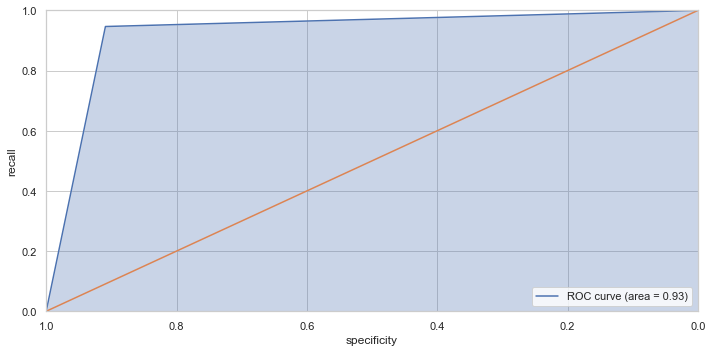

In [149]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logit_reg.predict(X_test))
roc_df = pd.DataFrame({'recall': tpr, 'specificity':1- fpr})
auc = metrics.auc(fpr, tpr)

ax = roc_df.plot(x='specificity', y='recall', figsize=(10, 5),label='ROC curve (area = %.2f)'%auc)
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
plt.grid(True)
plt.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

## Regression model that can predict average daily rate

In [195]:
hotel_lr = hotel.copy()
hotel_lr = hotel_lr.dropna()

hotel_lr = hotel_lr[['adr','hotel', 'lead_time', 
       'arrival_date_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type','deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 
       'required_car_parking_spaces', 'total_of_special_requests']]

#make category column numeric
hotel_lr = pd.get_dummies(hotel_lr,columns=['arrival_date_month','hotel','deposit_type','customer_type','meal','market_segment','reserved_room_type','distribution_channel','country'], dummy_na=True,drop_first=True)

In [196]:
features=hotel_lr.iloc[:,1:]
label = hotel_lr.iloc[:,0]

#standize data
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

#split the data to train and test data
X_train,X_test,y_train,y_test = train_test_split(scaled,label)

lg = LinearRegression()
lg.fit(X_train, y_train)

print('Score: {}'.format(lg.score(X_test,y_test)))
print(f'Intercept: {lg.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(features, lg.coef_):
    print(f' {name}: {coef}')

Score: -8.409166513608489e+24
Intercept: 1202514449771.688
Coefficients:
 lead_time: -4.349587854111224
 stays_in_weekend_nights: 2.879420496245899
 stays_in_week_nights: -4.391101292724486
 adults: 7.54666720199843
 children: 2.008876021629654
 babies: 149633517136195.62
 is_repeated_guest: -3.0964668468405234
 previous_cancellations: -1.2753765589040131
 previous_bookings_not_canceled: 2.2415639436178423
 agent: 1.9453125
 company: 6.521484375
 days_in_waiting_list: 12557204053030.287
 required_car_parking_spaces: 0.203125
 total_of_special_requests: -1.03515625
 arrival_date_month_August: -2.92578125
 arrival_date_month_December: -8.056640625
 arrival_date_month_February: -4.166015625
 arrival_date_month_January: -8.869140625
 arrival_date_month_July: 1.37890625
 arrival_date_month_June: -5.50390625
 arrival_date_month_March: -8.79296875
 arrival_date_month_May: -6.53515625
 arrival_date_month_November: -29.0517578125
 arrival_date_month_October: -11.501953125
 arrival_date_month_Se

In [192]:
fitted = lg.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, fitted))
r2 = r2_score(y_test, fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 20
r2: 0.6362


In [213]:
features=hotel_lr.iloc[:,1:]
label = hotel_lr.iloc[:,0]


lg = LinearRegression()
lg.fit(features, label)

print('Score: {}'.format(lg.score(X_test,y_test)))
print(f'Intercept: {lg.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(features, lg.coef_):
    print(f' {name}: {coef}')

Score: -60.53687571865814
Intercept: 55.272
Coefficients:
 lead_time: -0.1008050188610265
 stays_in_weekend_nights: -0.3520293267746272
 stays_in_week_nights: 0.07181065467304348
 adults: 11.102700756518892
 children: 13.297122355056054
 babies: 8.731593226229961e-11
 is_repeated_guest: 6.09151411592261
 previous_cancellations: 4.471629470690852
 previous_bookings_not_canceled: -3.731428028868038
 agent: -0.01886150764055472
 company: 0.05963772566174441
 days_in_waiting_list: -8.704148513061227e-13
 required_car_parking_spaces: 3.3109349444960574
 total_of_special_requests: -0.8717381767178409
 arrival_date_month_August: -28.20494116047117
 arrival_date_month_December: -52.76880853743558
 arrival_date_month_February: -38.972146960678025
 arrival_date_month_January: -44.487825117958565
 arrival_date_month_July: 4.038429804737197
 arrival_date_month_June: -21.876635813929013
 arrival_date_month_March: -52.87044661800736
 arrival_date_month_May: -28.06982338693716
 arrival_date_month_Nov

In [211]:
type(features)
type(label)

pandas.core.series.Series

In [214]:
model = sm.OLS(label, features.assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    adr   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     30.24
Date:                Mon, 13 Jul 2020   Prob (F-statistic):           1.29e-61
Time:                        14:50:54   Log-Likelihood:                -828.57
No. Observations:                 217   AIC:                             1777.
Df Residuals:                     157   BIC:                             1980.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
lead_time   

/opt/anaconda3/envs/tf3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/envs/tf3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [216]:
#Stepwise Regression
y = label

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(features[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(features[variables]), model)

best_model, best_variables = stepwise_selection(features.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, agent, company, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests, arrival_date_month_August, arrival_date_month_December, arrival_date_month_February, arrival_date_month_January, arrival_date_month_July, arrival_date_month_June, arrival_date_month_March, arrival_date_month_May, arrival_date_month_November, arrival_date_month_October, arrival_date_month_September, arrival_date_month_nan, hotel_Resort Hotel, hotel_nan, deposit_type_Non Refund, deposit_type_Refundable, deposit_type_nan, customer_type_Group, customer_type_Transient, customer_type_Transient-Party, customer_type_nan, meal_FB, meal_HB, meal_SC, meal_nan, market_segment_Corporate, market_segment_Direct, market_segment_Groups, market_segment_Offline TA/TO, market_segment_Online TA, market_segment_nan, reserved_room_type_C, reserved_r